# Análise das Metabases

In [42]:
import openml

In [43]:
dataset_ids = !ls -1 ../../metabase/*.csv | cut -d'/' -f4 | cut -d'_' -f1
dataset_ids = [int(e ) for e in dataset_ids]

In [44]:
df = openml.datasets.list_datasets(output_format='dataframe')
df = df.loc[dataset_ids]
df

,did,name,version,uploader,status,format,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures
1005,1005,glass,2,2,active,ARFF,138.0,2.0,76.0,2.0,10.0,214.0,0.0,0.0,9.0,1.0
1012,1012,flags,2,2,active,ARFF,125.0,14.0,69.0,2.0,29.0,194.0,0.0,0.0,2.0,27.0
1014,1014,analcatdata_dmft,2,2,active,ARFF,642.0,9.0,155.0,2.0,5.0,797.0,0.0,0.0,0.0,5.0
1016,1016,vowel,3,2,active,ARFF,900.0,15.0,90.0,2.0,14.0,990.0,0.0,0.0,10.0,4.0
1061,1061,ar4,1,2,active,ARFF,87.0,2.0,20.0,2.0,30.0,107.0,0.0,0.0,29.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
917,917,fri_c1_1000_25,2,2,active,ARFF,546.0,2.0,454.0,2.0,26.0,1000.0,0.0,0.0,25.0,1.0
951,951,arsenic-male-lung,2,2,active,ARFF,546.0,43.0,13.0,2.0,5.0,559.0,0.0,0.0,3.0,2.0
965,965,zoo,2,2,active,ARFF,60.0,2.0,41.0,2.0,17.0,101.0,0.0,0.0,1.0,16.0
987,987,collins,2,2,active,ARFF,420.0,15.0,80.0,2.0,23.0,500.0,0.0,0.0,20.0,3.0


<Axes: title={'center': 'Number of Classes'}, ylabel='Frequency'>

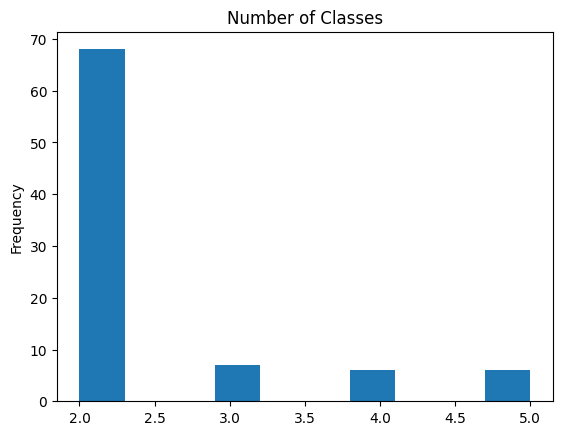

In [46]:
df.NumberOfClasses.plot(kind='hist', title="Number of Classes")

<Axes: title={'center': 'Number of Instances'}, ylabel='Frequency'>

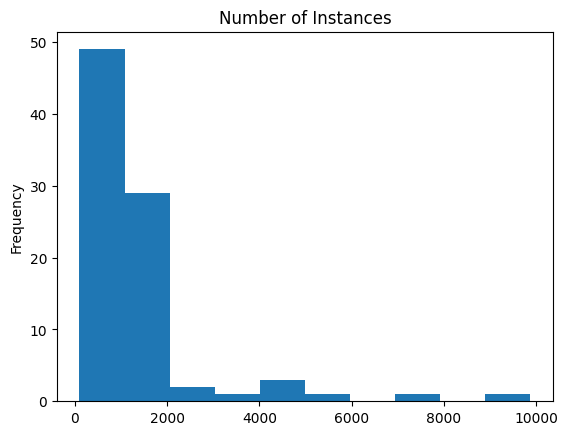

In [47]:
df.NumberOfInstances.plot(kind='hist', title="Number of Instances")

<Axes: title={'center': 'Number of Features'}, ylabel='Frequency'>

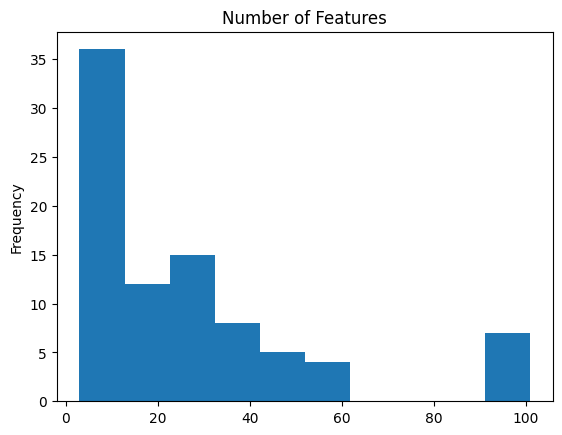

In [48]:
df.NumberOfFeatures.plot(kind='hist', title="Number of Features")